In [ ]:
def simulate_training_data() -> pd.DataFrame:
    """Simulate historical conversion data for Orbit model training."""

def train_orbit_model(training_data: pd.DataFrame) -> object:
    """Train an Orbit DLT model on historical data and return the fitted model."""

def forecast_counterfactual(model: object, forecast_period: pd.DataFrame) -> pd.DataFrame:
    """Generate forecasted conversion rates and uncertainty for the test period."""

def sample_posterior_forecast(forecast_output: pd.DataFrame, n_samples: int) -> np.ndarray:
    """Sample from the posterior forecast distribution (e.g., draws from forecast intervals)."""

def fit_beta_from_samples(samples: np.ndarray) -> Tuple[float, float]:
    """Fit a Beta distribution (α, β) to posterior samples."""

def observe_ab_data(test_data: pd.DataFrame) -> Tuple[int, int, int, int]:
    """Extract successes and trials for variant A and B from test data."""

def bayesian_ab_test(a_success: int, a_total: int, b_success: int, b_total: int,
                     prior_a: Tuple[float, float], prior_b: Tuple[float, float]) -> Dict:
    """Perform Bayesian A/B test using Beta priors and report win probabilities and lift."""

def visualize_results(result_dict: Dict) -> None:
    """Plot posterior distributions and win probabilities for interpretation."""


In [5]:
import pandas as pd
import numpy as np

def simulate_training_data(
    start_date: str = "2025-01-01",
    days: int = 180,
    base_rate: float = 0.05,
    trend_slope: float = 0.0001,
    seasonality_amplitude: float = 0.005,
    noise_sd: float = 0.01,
    n_trials: int = 1000,
    holiday_dates: list = None
) -> pd.DataFrame:
    dates = pd.date_range(start=start_date, periods=days, freq='D')
    data = []

    for i, date in enumerate(dates):
        day_of_week = date.weekday()
        date_str = date.strftime('%Y-%m-%d')

        trend = trend_slope * i
        seasonality = seasonality_amplitude * np.sin(2 * np.pi * day_of_week / 7)
        noise = np.random.normal(0, noise_sd)

        weekend_multiplier = 0.5 if day_of_week >= 5 else 1.0
        holiday_multiplier = 0.5 if holiday_dates and date_str in holiday_dates else 1.0
        multiplier = min(weekend_multiplier, holiday_multiplier)

        effective_base = base_rate * multiplier
        final_rate = effective_base + trend + seasonality + noise
        final_rate = np.clip(final_rate, 0.0001, 0.9999)

        data.append({
            "date": date,
            "conversion_rate": final_rate,
            "trend": trend,
            "seasonality": seasonality,
            "base_rate": effective_base,
            "noise": noise
        })

    return pd.DataFrame(data)



In [77]:
holiday_list = ["2025-02-14", "2025-04-01", "2025-12-25"]


df = simulate_training_data( holiday_dates=holiday_list)


In [78]:
import matplotlib.pyplot as plt

def plot_simulation_components(df: pd.DataFrame):
    plt.figure(figsize=(12, 6))
    plt.plot(df["date"], df["conversion_rate"], label="Final Conversion Rate", linewidth=2)
    plt.plot(df["date"], df["trend"] + df["base_rate"], label="Trend + Base", linestyle=":")
    plt.plot(df["date"], df["seasonality"] + df["base_rate"], label="Seasonality + Base", linestyle="--")
    #plt.plot(df["date"], df["base_rate"], label="Base Rate (with penalties)", linestyle="-.")
    plt.xlabel("Date")
    plt.ylabel("Conversion Rate")
    plt.title("Simulated Conversion Rate Components")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()





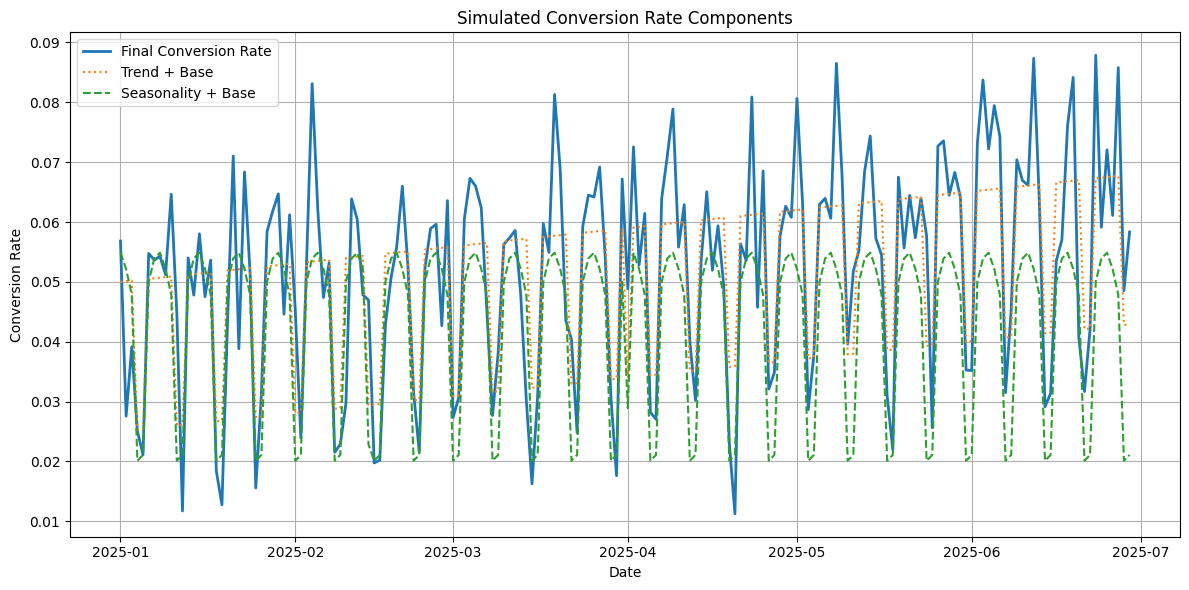

In [8]:
plot_simulation_components(df)

In [79]:
df["is_weekend"] = df["date"].dt.weekday >= 5
df["is_weekend"] = df["is_weekend"].astype(int)

df["day_of_week"] = df["date"].dt.weekday
df = pd.get_dummies(df, columns=["day_of_week"], drop_first=True)



In [80]:
df.columns

Index(['date', 'conversion_rate', 'trend', 'seasonality', 'base_rate', 'noise',
       'is_weekend', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
       'day_of_week_4', 'day_of_week_5', 'day_of_week_6'],
      dtype='object')

In [109]:
from orbit.models import DLT
from orbit.diagnostics.backtest import BackTester

def train_orbit_model(training_data: pd.DataFrame, seasonality=None, regressor_columns=None ) -> (DLT, BackTester):
    """Run Orbit DLT model with sliding-window backtest and return the BackTester object."""

    model = DLT(
        date_col="date",
        response_col="conversion_rate",
        estimator="stan-mcmc",
        seasonality=seasonality,
        regressor_col=regressor_columns,
         suppress_stan_log=True  
    )
    
    model.fit(df=training_data)

    bt = BackTester(
        model=model,
        df=training_data,
        forecast_len=7,
        min_train_len=30,
        incremental_len=7,
        window_type="rolling"
    )

    bt.fit_predict()

    return model, bt




In [111]:
model_day_of_week, bt_day_of_week = train_orbit_model(df, regressor_columns=[col for col in df.columns if col.startswith("day_of_week_")])

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [101]:
model_seasonality_and_is_weekend, bt_seasonality_and_is_weekend = train_orbit_model(df, seasonality=7, regressor_columns=['is_weekend'])

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

TypeError: TimeSeriesSplitter.__init__() got an unexpected keyword argument 'suppress_stan_log'

In [ ]:
import logging
logging.getLogger("orbit").setLevel(logging.WARNING)

model_naive, bt_naive = train_orbit_model(df)

model_seasonality, bt_seasonality = train_orbit_model(df, seasonality=7)

model_is_weekend, bt_is_weekend = train_orbit_model(df,regressor_columns=['is_weekend'])


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

NameError: name 'train_seasonality_and_is_weekend' is not defined

In [112]:
from orbit.diagnostics.metrics import smape, mae, rmsse, mse

def rmsse_mean(test_actual, test_prediction, train_actual):
    """
    RMSSE-style metric using the training mean as the naive forecast baseline.

    Returns:
        model_rmse / naive_mean_rmse
        < 1 => model better than mean forecast
    """
    import numpy as np

    test_actual = np.array(test_actual)
    test_prediction = np.array(test_prediction)
    train_actual = np.array(train_actual)

    # Model RMSE
    model_rmse = np.sqrt(np.mean((test_actual - test_prediction) ** 2))

    # Naive forecast: training mean
    mean_forecast = np.mean(train_actual)
    naive_rmse = np.sqrt(np.mean((test_actual - mean_forecast) ** 2))

    return model_rmse / naive_rmse


print(bt_naive.score(metrics=[smape, mae,rmsse,rmsse_mean]))
print(bt_seasonality.score(metrics=[smape, mae,rmsse,rmsse_mean]))
print(bt_is_weekend.score(metrics=[smape, mae,rmsse,rmsse_mean]))
print(bt_seasonality_and_is_weekend.score(metrics=[smape, mae,rmsse,rmsse_mean]))
print(bt_day_of_week.score(metrics=[smape, mae,rmsse,rmsse_mean]))

# smape: percentage deviation 
# mae: absolute deviation
# rmsse : default naive comparision to lag-1 forecast
# rmsse_mean : rather compare against the overall mean



  metric_name  metric_values  is_training_metric
0       smape       0.284967               False
1         mae       0.014012               False
2       rmsse       0.899809               False
3  rmsse_mean       1.075085               False
  metric_name  metric_values  is_training_metric
0       smape       0.209071               False
1         mae       0.009899               False
2       rmsse       0.631898               False
3  rmsse_mean       0.754987               False
  metric_name  metric_values  is_training_metric
0       smape       0.189766               False
1         mae       0.008966               False
2       rmsse       0.565994               False
3  rmsse_mean       0.676245               False
  metric_name  metric_values  is_training_metric
0       smape       0.206509               False
1         mae       0.009756               False
2       rmsse       0.619429               False
3  rmsse_mean       0.740089               False
  metric_name  metri

In [114]:
predicted_df = model_is_weekend.predict(df)


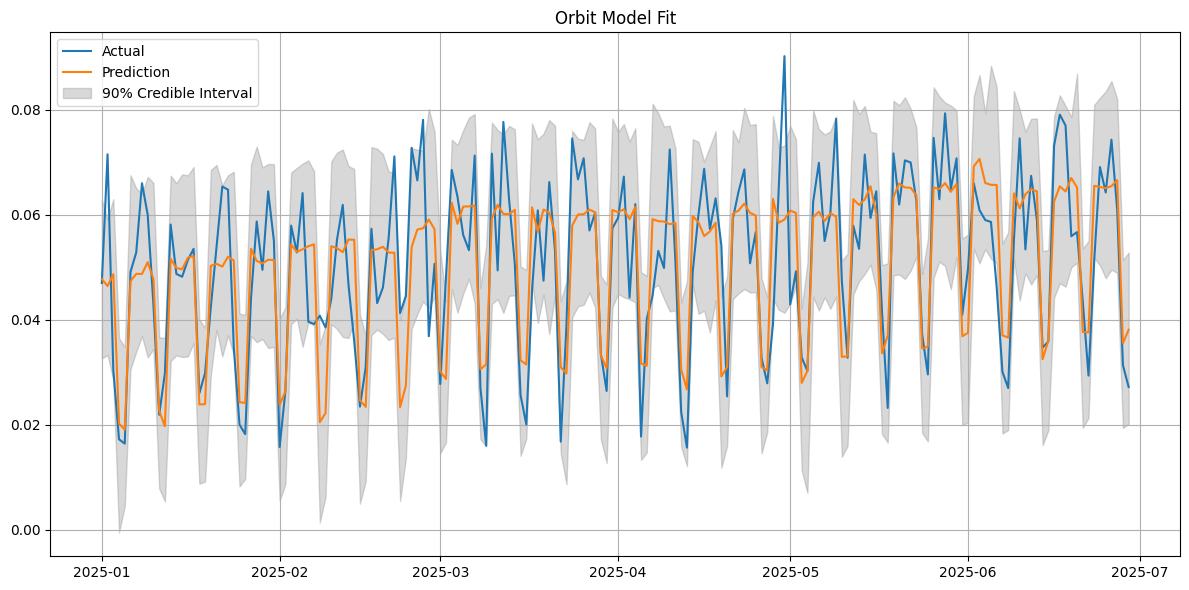

In [115]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df["date"], df["conversion_rate"], label="Actual")
plt.plot(predicted_df["date"], predicted_df["prediction"], label="Prediction")
plt.fill_between(predicted_df["date"], predicted_df["prediction_5"], predicted_df["prediction_95"],
                 color="gray", alpha=0.3, label="90% Credible Interval")
plt.legend()
plt.title("Orbit Model Fit")
plt.grid(True)
plt.tight_layout()
plt.show()


## Forecast with selected model

In [155]:
from datetime import timedelta

# 1. Create future dates
last_date = df["date"].max()
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=14)

# 2. Build future DataFrame
future_df = pd.DataFrame({"date": future_dates})

# 3. Add required regressors
future_df["is_weekend"] = future_df["date"].dt.weekday >= 5
future_df["is_weekend"] = future_df["is_weekend"].astype(int)


# 4. Predict
future_preds = model_is_weekend.predict(df=future_df,return_raw=True)


In [156]:
future_preds

,date,prediction_5,prediction,prediction_95
0,2025-06-30,0.050269,0.065015,0.078171
1,2025-07-01,0.048593,0.064874,0.083002
2,2025-07-02,0.048592,0.063655,0.080908
3,2025-07-03,0.047572,0.063176,0.078451
4,2025-07-04,0.047418,0.064519,0.082731
5,2025-07-05,0.019154,0.034744,0.052649
6,2025-07-06,0.017289,0.036279,0.051443
7,2025-07-07,0.048497,0.062528,0.077640
8,2025-07-08,0.047358,0.065960,0.086324
9,2025-07-09,0.049657,0.062913,0.077498


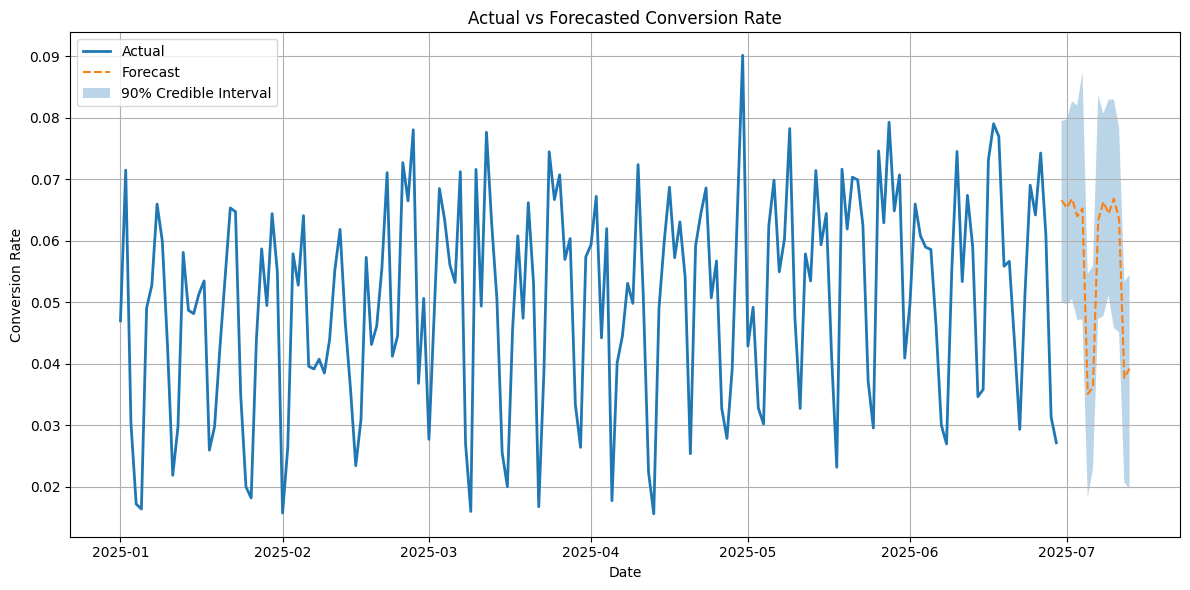

In [143]:
import matplotlib.pyplot as plt

# Combine historical and future predictions if needed
# For now, assume `df` is your training data, and `future_preds` is forecast
preds = pd.concat([df[["date", "conversion_rate"]], future_preds], ignore_index=True)

plt.figure(figsize=(12, 6))

# Actuals
plt.plot(df["date"], df["conversion_rate"], label="Actual", linewidth=2)

# Forecast
plt.plot(future_preds["date"], future_preds["prediction"], label="Forecast", linestyle="--")

# Credible interval
plt.fill_between(future_preds["date"],
                 future_preds["prediction_5"],
                 future_preds["prediction_95"],
                 alpha=0.3, label="90% Credible Interval")

plt.legend()
plt.xlabel("Date")
plt.ylabel("Conversion Rate")
plt.title("Actual vs Forecasted Conversion Rate")
plt.grid(True)
plt.tight_layout()
plt.show()


In [157]:
import numpy as np
import matplotlib.pyplot as plt

# Get posterior samples from model
samples = model_is_weekend.get_posterior_samples()

# Extract level and regression components
lev_sm = samples["lev_sm"]  # shape: (n_draws, T)
beta = samples["beta"]      # shape: (n_draws, n_regressors)
sigma = samples["obs_sigma"]  # shape: (n_draws,)

# Forecast range
n_forecast_days = future_df.shape[0]
n_draws = lev_sm.shape[0]

# Assume the forecast starts right after the training period
start_idx = lev_sm.shape[1] - n_forecast_days
forecast_lev_sm = lev_sm[:, start_idx:]

# Prepare regressor matrix
regressor_names = model_is_weekend._model_config.regressor_col
X_future = future_df[regressor_names].values  # shape: (n_days, n_regressors)

# Build predictive samples: one sample path per draw
forecast_samples = np.zeros((n_draws, n_forecast_days))
for i in range(n_draws):
    mean = forecast_lev_sm[i] + X_future @ beta[i]
    noise = np.random.normal(0, sigma[i], size=n_forecast_days)
    forecast_samples[i] = mean + noise

# Visualize
plt.figure(figsize=(12, 6))

# Plot 50 random sample paths
for i in np.random.choice(n_draws, size=50, replace=False):
    plt.plot(future_df["date"], forecast_samples[i], alpha=0.2, color="orange")

# Plot median forecast
median_forecast = np.median(forecast_samples, axis=0)
plt.plot(future_df["date"], median_forecast, color="black", linewidth=2, label="Median Forecast")

plt.title("Posterior Predictive Forecast Samples")
plt.xlabel("Date")
plt.ylabel("Conversion Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


IndexError: tuple index out of range

In [159]:
for k, v in samples.items():
    print(f"{k}: {v.shape}")


l: (100, 180)
b: (100, 180)
lev_sm: (100,)
slp_sm: (100,)
obs_sigma: (100,)
nu: (100,)
lt_sum: (100, 180)
beta: (100, 1)
gt_sum: (100, 180)
gb: (100, 1)
gl: (100, 1)
loglk: (100, 179, 1)


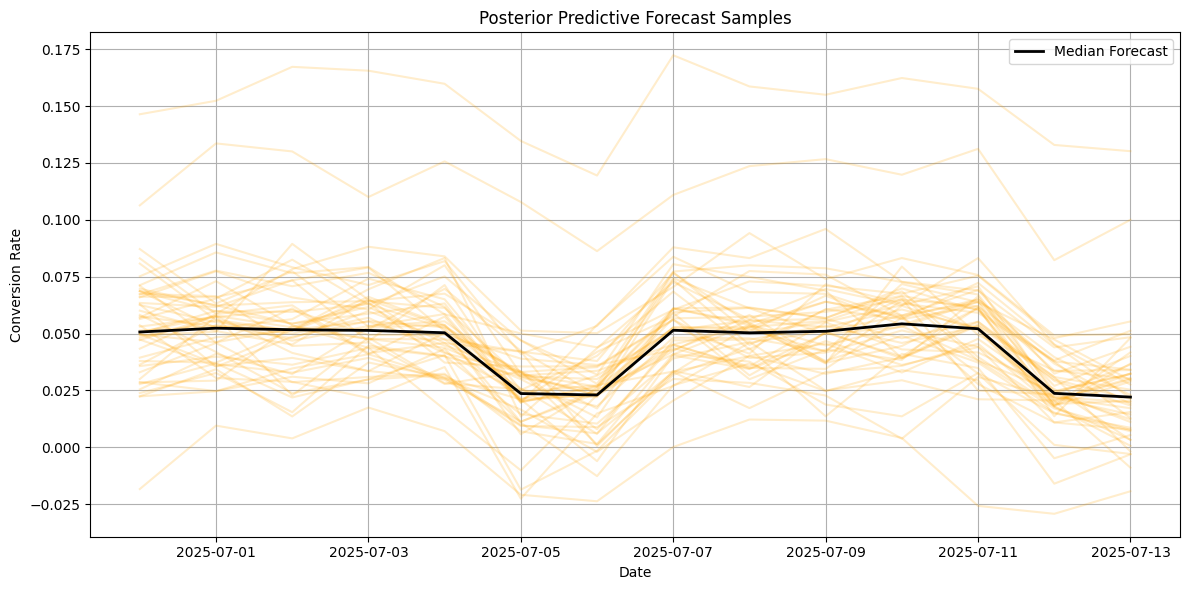

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Use 'l' instead of 'lev_sm' for latent level samples
level = samples["l"]  # shape: (n_draws, T)
beta = samples["beta"]  # shape: (n_draws, n_regressors)
sigma = samples["obs_sigma"]  # shape: (n_draws,)

# Forecast range
n_forecast_days = future_df.shape[0]
n_draws = level.shape[0]
T = level.shape[1]

# Take the last N days of the latent level for forecast
forecast_level = level[:, -n_forecast_days:]

# Prepare future regressors
regressor_names = ["is_weekend"]
X_future = future_df[regressor_names].values


# Build predictive samples: one sample path per draw
forecast_samples = np.zeros((n_draws, n_forecast_days))
for i in range(n_draws):
    mean = forecast_level[i] + X_future @ beta[i]
    noise = np.random.normal(0, sigma[i], size=n_forecast_days)
    forecast_samples[i] = mean + noise

# Visualize
plt.figure(figsize=(12, 6))

# Plot 50 random sample paths
for i in np.random.choice(n_draws, size=50, replace=False):
    plt.plot(future_df["date"], forecast_samples[i], alpha=0.2, color="orange")

# Plot median forecast
median_forecast = np.median(forecast_samples, axis=0)
plt.plot(future_df["date"], median_forecast, color="black", linewidth=2, label="Median Forecast")

plt.title("Posterior Predictive Forecast Samples")
plt.xlabel("Date")
plt.ylabel("Conversion Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [162]:
samples

{'l': array([[0.0556129, 0.0570571, 0.0562713, ..., 0.0566391, 0.0563103,
         0.0556871],
        [0.0566194, 0.0580544, 0.0572682, ..., 0.0576273, 0.0573639,
         0.0568244],
        [0.0530781, 0.0542849, 0.0536073, ..., 0.054479 , 0.0542386,
         0.0537679],
        ...,
        [0.0479738, 0.0498931, 0.0484799, ..., 0.0609786, 0.0606323,
         0.0599765],
        [0.0444013, 0.0452773, 0.0446998, ..., 0.0498553, 0.04961  ,
         0.0492077],
        [0.0571301, 0.0574376, 0.0573594, ..., 0.0610155, 0.0609026,
         0.0606978]], shape=(100, 180)),
 'b': array([[ 0.00000e+00,  3.87960e-04,  1.59049e-05, ..., -1.56251e-05,
         -9.74739e-05, -2.24430e-04],
        [ 0.00000e+00,  3.77980e-04,  1.56466e-05, ..., -3.69107e-05,
         -9.11287e-05, -1.95803e-04],
        [ 0.00000e+00,  2.78011e-04,  1.50708e-05, ..., -3.68309e-05,
         -7.80625e-05, -1.56493e-04],
        ...,
        [ 0.00000e+00,  5.60555e-05,  2.25903e-06, ...,  2.25396e-06,
         -

In [163]:
import numpy as np

sigma = samples["obs_sigma"]
print("Mean sigma:", np.mean(sigma))
print("Std of sigma:", np.std(sigma))
print("Var of sigma:", np.var(sigma))


Mean sigma: 0.0098814532
Std of sigma: 0.0005475985039403961
Var of sigma: 2.9986412151776e-07
